In [ ]:
!pip install aenum
!pip install eo-learn
!pip install geopandas
# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.mask import AddMultiCloudMaskTask, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 10.5MB 6.0MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 42.9MB 102kB/s 
     |████████████████████████████████| 4.8MB 26.4MB/s 
     |████████████████████████████████| 972kB 42.4MB/s 
     |████████████████████████████████| 18.3MB 1.3MB/s 
     |████████████████████████████████| 133kB 17.3MB/s 
     |████████████████████████████████| 194kB 50.5MB/s 
     |████████████████████████████████| 133kB 46.1MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 6.5MB 35.9MB/s 
     |████████████████████████████████| 14.8MB 348kB/s 
     |████████████████████████████████| 7.1MB 41.5MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 1.4MB 30.6MB/s 
  Created wheel for s2cloudless: filename=s2cloudless-1.4.0-cp36-none-any.whl size=4763249 sha256=49d29724253f4a

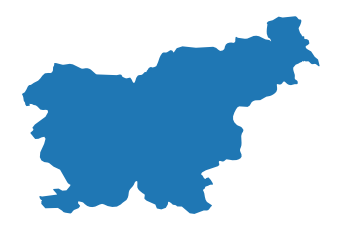

In [ ]:

# Load geojson file
country = gpd.read_file('/content/SVN.geojson')
country = country.buffer(500)

# Get the country's shape in polygon format
country_shape = country.geometry.values[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size
#print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],country_shape.bounds[3] - country_shape.bounds[1]))

In [ ]:
# Create the splitter to obtain a list of bboxes
bbox_splitter = UtmZoneSplitter([country_shape], country.crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y},
                           crs=country.crs,
                           geometry=geometry)

# select a 5x5 area (id of center patch)
ID = 616

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 2 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 2):
        patchIDs.append(idx)

# Check if final size is 5x5
if len(patchIDs) != 5*5:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# save to shapefile
shapefile_name = './grid_slovenia_500x500.gpkg'
gdf.to_file(shapefile_name, driver='GPKG')

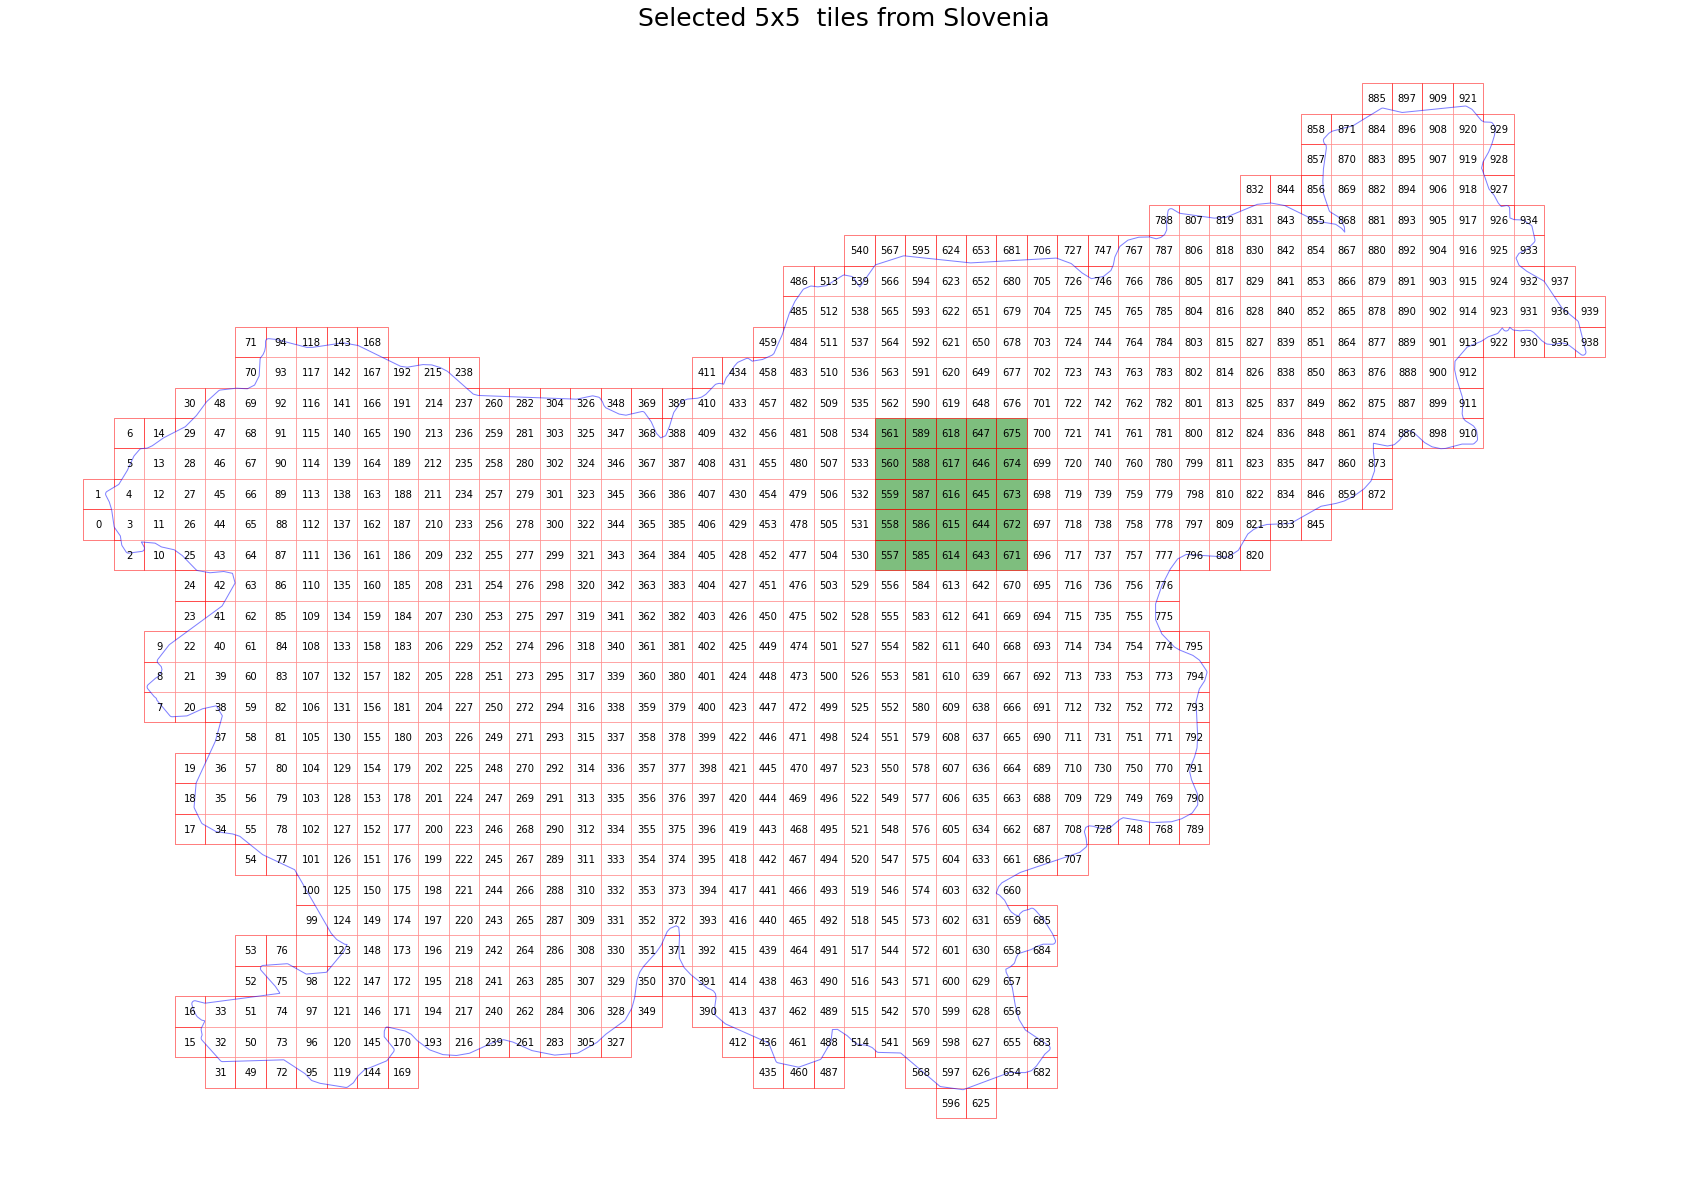

In [ ]:
# figure
fig, ax = plt.subplots(figsize=(30, 30))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 5x5  tiles from Slovenia', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center')

gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

In [ ]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch

# TASK FOR BAND DATA
# add a request for S2 bands
# Here we also do a simple filter of cloudy scenes (on tile level)
# s2cloudless masks and probabilities are requested via additional data
band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
    max_threads=5
)


# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), band_names.index('B04')])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'),
                                     [band_names.index('B03'), band_names.index('B08')])
ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDBI'),
                                     [band_names.index('B11'), band_names.index('B08')])



# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [ ]:
band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA')],
)

add_clm = AddMultiCloudMaskTask(data_feature='BANDS',
                                all_bands=True,
                                processing_resolution=160,
                                mono_features=('CLP', 'CLM'),
                                mask_feature=None,
                                average_over=16,
                                dilation_size=8)

In [ ]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'
    CULTIVATED_LAND    = 'Cultivated Land',    1,  '#ffff00'
    FOREST             = 'Forest',             2,  '#054907'
    GRASSLAND          = 'Grassland',          3,  '#ffa500'
    SHRUBLAND          = 'Shrubland',          4,  '#806000'
    WATER              = 'Water',              5,  '#069af3'
    WETLAND            = 'Wetlands',           6,  '#95d0fc'
    TUNDRA             = 'Tundra',             7,  '#967bb6'
    ARTIFICIAL_SURFACE = 'Artificial Surface', 8,  '#dc143c'
    BARELAND           = 'Bareland',           9,  '#a6a6a6'
    SNOW_AND_ICE       = 'Snow and Ice',       10, '#000000'

    @property
    def id(self):
        """ Returns an ID of an enum type

        :return: An ID
        :rtype: int
        """
        return self.values[1]

    @property
    def color(self):
        """ Returns class color

        :return: A color in hexadecimal representation
        :rtype: str
        """
        return self.values[2]


def get_bounds_from_ids(ids):
    bounds = []
    for i in range(len(ids)):
        if i < len(ids) - 1:
            if i == 0:
                diff = (ids[i + 1] - ids[i]) / 2
                bounds.append(ids[i] - diff)
            diff = (ids[i + 1] - ids[i]) / 2
            bounds.append(ids[i] + diff)
        else:
            diff = (ids[i] - ids[i - 1]) / 2
            bounds.append(ids[i] + diff)
    return bounds


# Reference colormap things
lulc_bounds = get_bounds_from_ids([x.id for x in LULC])
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm(lulc_bounds, lulc_cmap.N)

In [ ]:
# takes some time due to the large size of the reference data
#land_use_ref_path = os.path.join('/content/SVN.geojson,/content/land_use_10class_reference_slovenia.gpkg')
land_use_ref = gpd.read_file("/content/SVN.geojson")

rasterization_task = VectorToRaster(land_use_ref, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='lulcid', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint8)

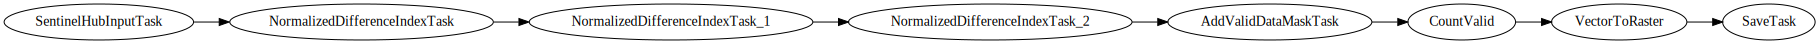

In [ ]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    ndvi,
    ndwi,
    ndbi,
    add_sh_valmask,
    count_val_sh,
    rasterization_task,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [ ]:
%%time

# Execute the workflow
time_interval = ['2019-01-01', '2019-12-31'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()


CPU times: user 252 ms, sys: 76.2 ms, total: 329 ms
Wall time: 856 ms


In [ ]:
!wget http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019_sample.zip

--2020-12-12 03:24:12--  http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019_sample.zip
Resolving eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com (eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com)... 52.219.47.205
Connecting to eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com (eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com)|52.219.47.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9957077222 (9.3G) [application/zip]
Saving to: ‘eopatches_slovenia_2019_sample.zip’

eopatches_slovenia_ 100%[===================>]   9.27G  27.7MB/s    in 5m 47s  

2020-12-12 03:29:59 (27.4 MB/s) - ‘eopatches_slovenia_2019_sample.zip’ saved [9957077222/9957077222]



In [ ]:
 !wget http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eow_material.zip

In [ ]:
!unzip -qq eow_material.zip

In [ ]:
EOPatch.load('/content/eopatches/eopatch_0')

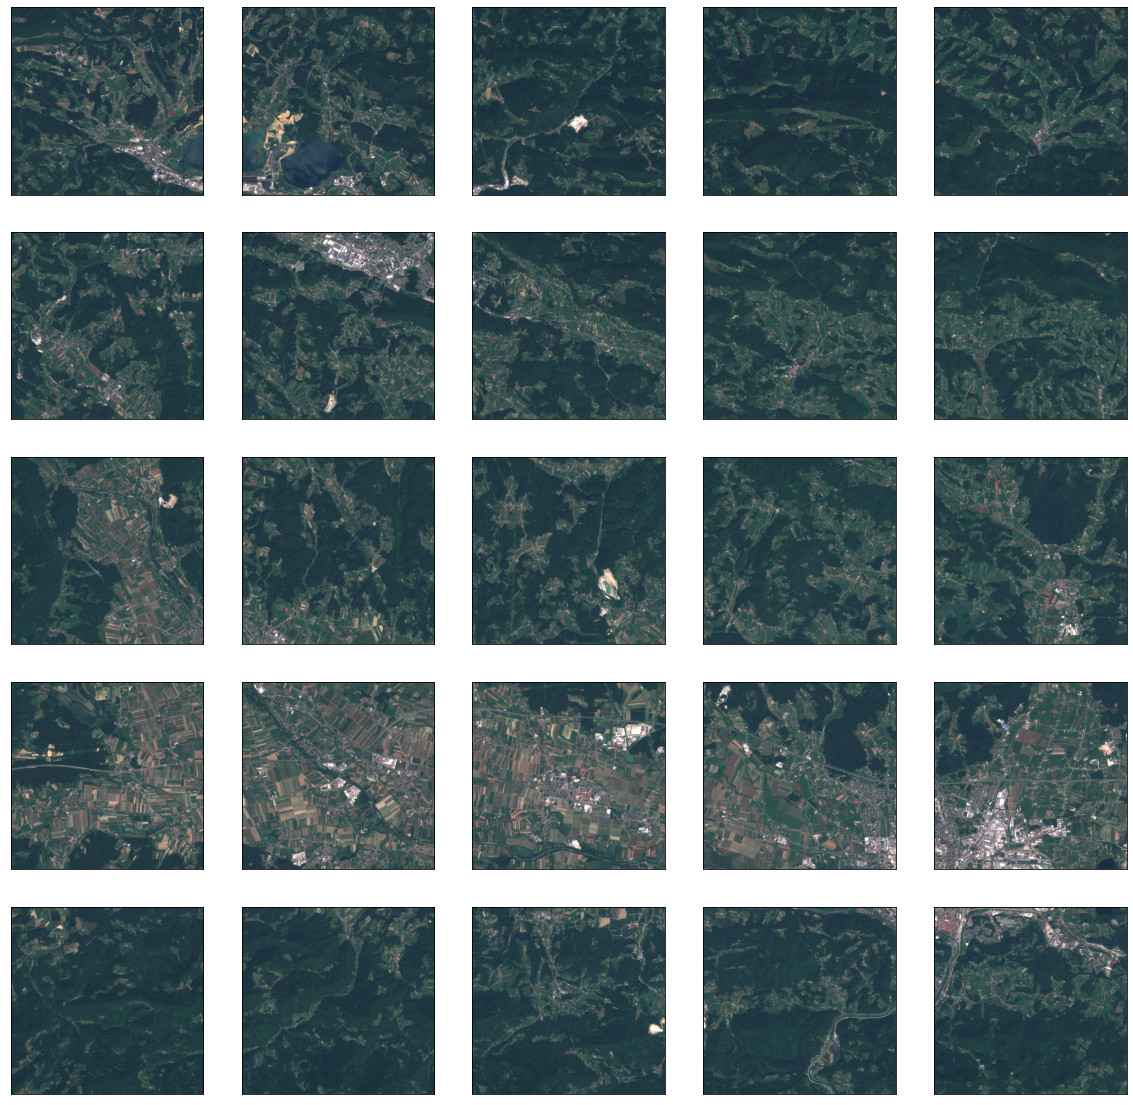

In [ ]:
#Let’s select a date and draw the closest timestamp for each eopatch.

# Draw the RGB image
path_out = '/content/eopatches'
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

date = datetime.datetime(2019,7,1)

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//5][i%5]
    dates = np.array(eopatch.timestamp)
    closest_date_id = np.argsort(abs(date-dates))[0]
    ax.imshow(np.clip(eopatch.data['BANDS'][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

#fig.subplots_adjust(wspace=0, hspace=0)

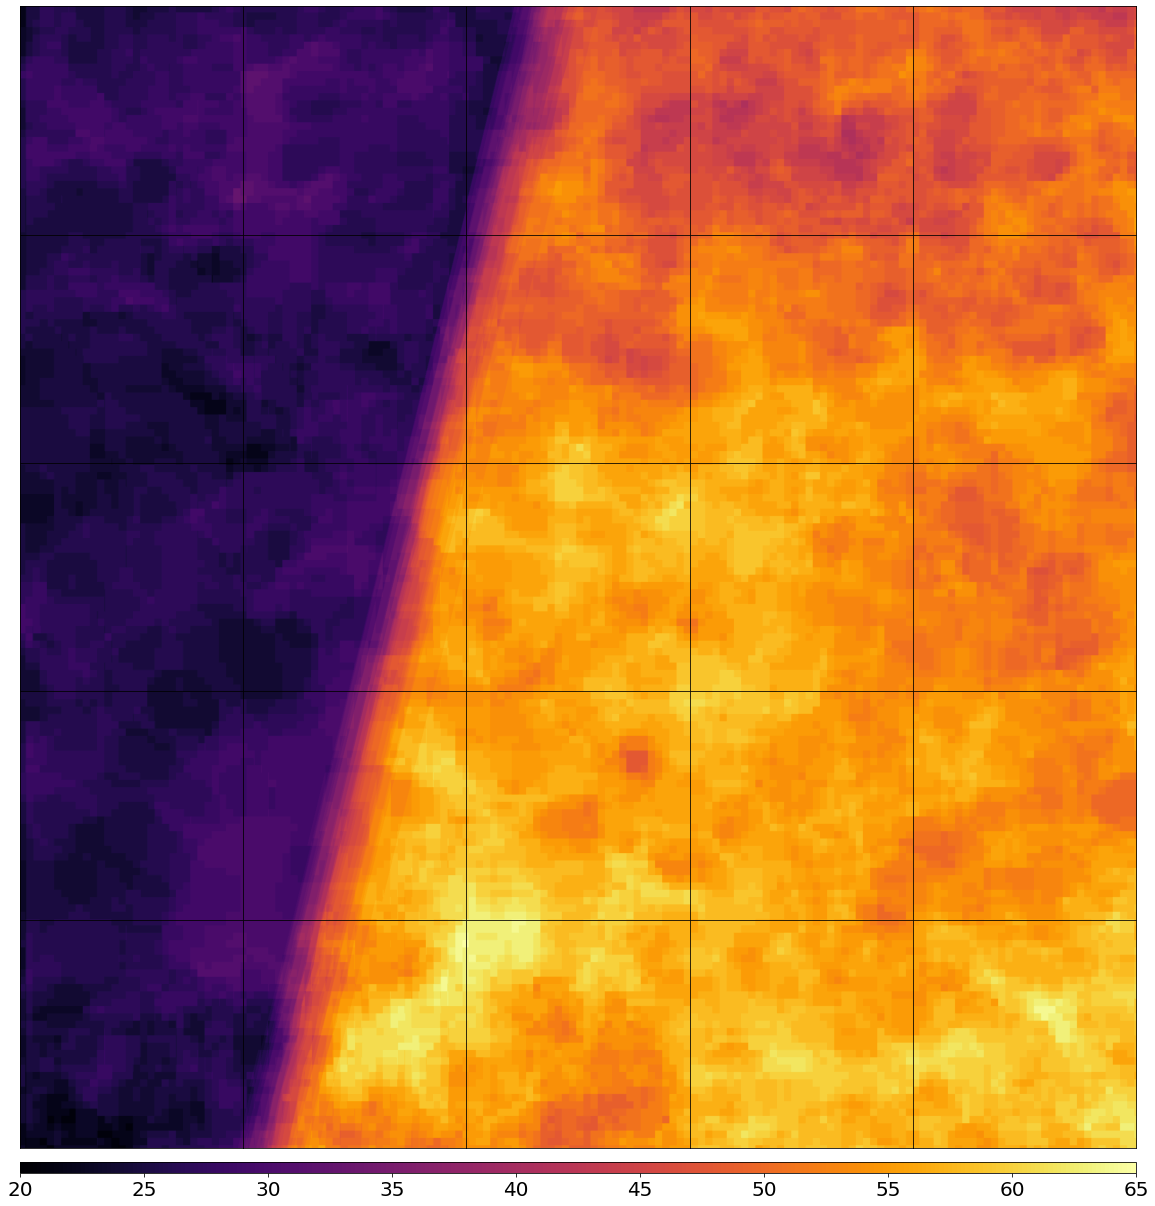

In [ ]:
path_out = '/content/eopatches'

vmin, vmax = None, None
for i in range(len(patchIDs)):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    data = eopatch.mask_timeless['VALID_COUNT'].squeeze()
    vmin = np.min(data) if vmin is None else (np.min(data) if np.min(data) < vmin else vmin)
    vmax = np.max(data) if vmax is None else (np.max(data) if np.max(data) > vmax else vmax)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//5][i%5]
    im = ax.imshow(eopatch.mask_timeless['VALID_COUNT'].squeeze(), vmin=vmin, vmax=vmax, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


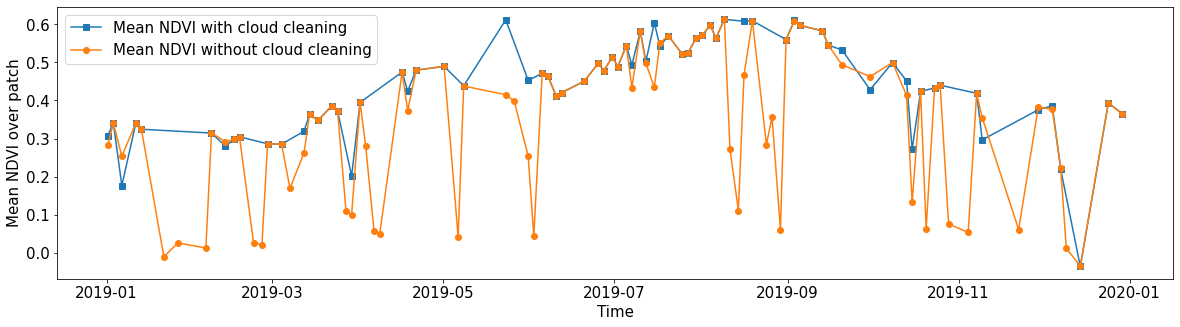

In [ ]:
eID = 16
eopatch = EOPatch.load(f'{path_out}/eopatch_{eID}', lazy_loading=True)

ndvi = eopatch.data['NDVI'] # ndvi data cube
mask = eopatch.mask['IS_VALID'] # mask of valid pixels
time = np.array(eopatch.timestamp) # x axis
t, w, h, _ = ndvi.shape

ndvi_clean = ndvi.copy()
ndvi_clean[~mask] = np.nan # set values of invalid pixels to NaN's

# Calculate means, remove NaN's from means
ndvi_mean = np.nanmean(ndvi.reshape(t, w * h).squeeze(), axis=1)
ndvi_mean_clean = np.nanmean(ndvi_clean.reshape(t, w * h).squeeze(), axis=1)
time_clean = time[~np.isnan(ndvi_mean_clean)]
ndvi_mean_clean = ndvi_mean_clean[~np.isnan(ndvi_mean_clean)]

fig = plt.figure(figsize=(20,5))
plt.plot(time_clean, ndvi_mean_clean, 's-', label = 'Mean NDVI with cloud cleaning')
plt.plot(time, ndvi_mean, 'o-', label='Mean NDVI without cloud cleaning')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Mean NDVI over patch', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc=2, prop={'size': 15});

[Text(0, 0, 'NO_DATA'),
 Text(0, 0, 'CULTIVATED_LAND'),
 Text(0, 0, 'FOREST'),
 Text(0, 0, 'GRASSLAND'),
 Text(0, 0, 'SHRUBLAND'),
 Text(0, 0, 'WATER'),
 Text(0, 0, 'WETLAND'),
 Text(0, 0, 'TUNDRA'),
 Text(0, 0, 'ARTIFICIAL_SURFACE'),
 Text(0, 0, 'BARELAND'),
 Text(0, 0, 'SNOW_AND_ICE')]

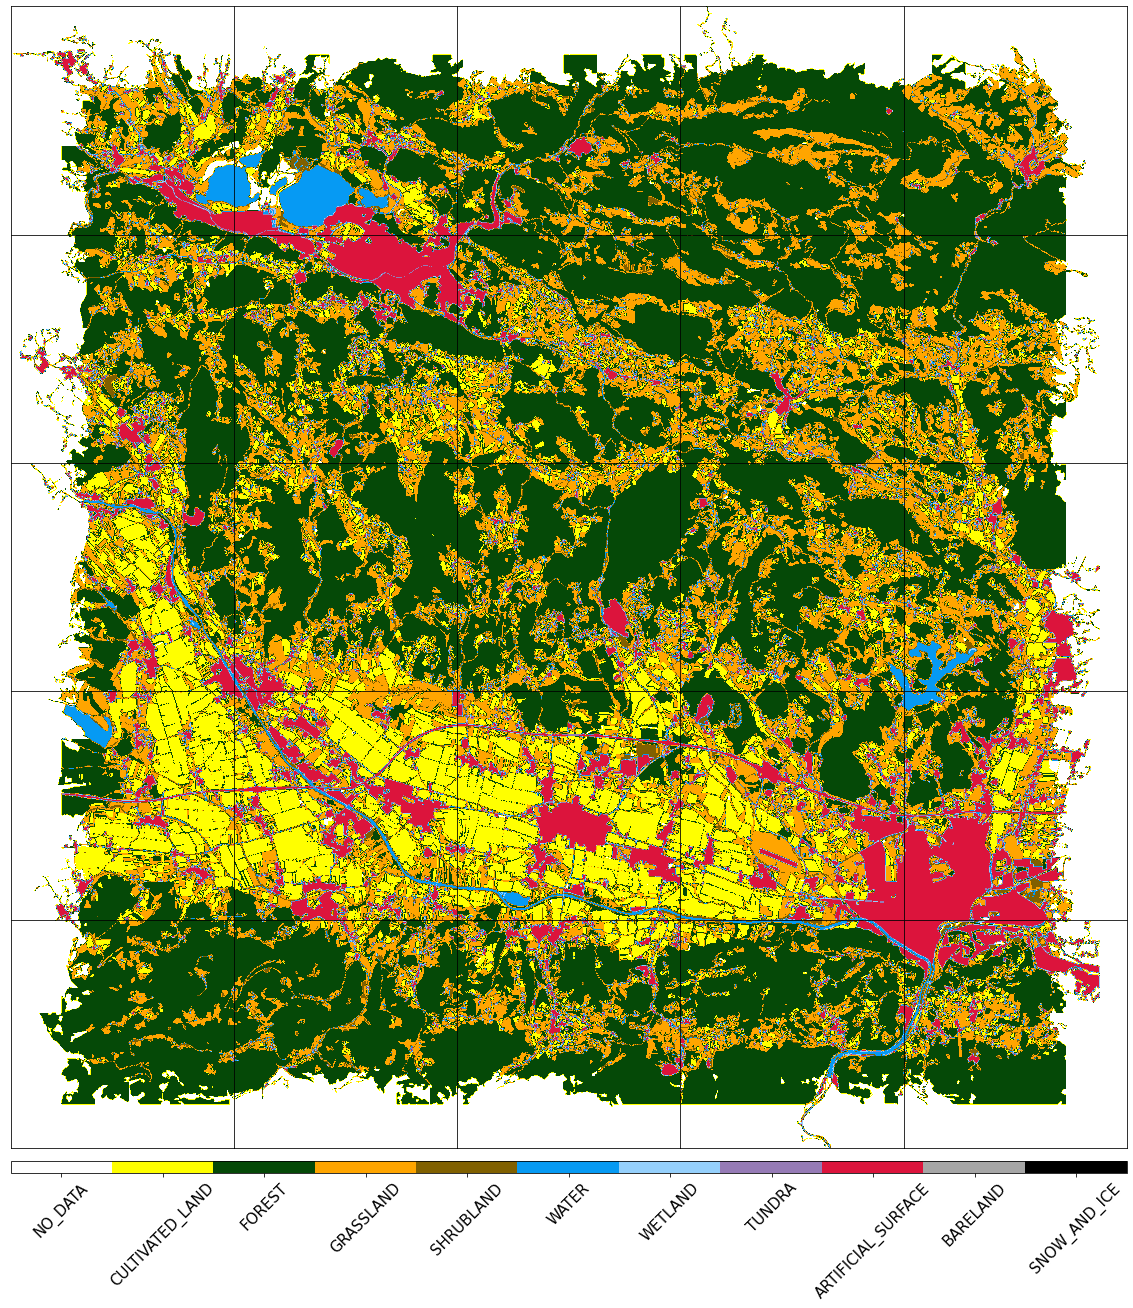

In [ ]:
#Visualize the reference map
path_out = '/content/eopatches'

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//5][i%5]
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
#plt.show()

In [ ]:
path_out = '/content/eopatches'

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//5][i%5]
    ndvi = eopatch.data['NDVI']
    mask = eopatch.mask['IS_VALID']
    ndvi[~mask] = np.nan
    ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()
    im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

In [ ]:
path_out = '/content/eopatches'

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//5][i%5]
    clp = eopatch.data['CLP'].astype(float)/255
    mask = eopatch.mask['IS_VALID']
    clp[~mask] = np.nan
    clp_mean = np.nanmean(clp, axis=0).squeeze()
    im = ax.imshow(clp_mean, vmin=0.0, vmax=0.3, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

In [ ]:
#Define EO Tasks

In [ ]:
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold
# TASK TO LOAD EXISTING EOPATCHES
path_out='/content/eopatches'
load = LoadTask(path_out)

# TASK FOR CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ['BANDS', 'NDVI', 'NDWI', 'NDBI']},
                               (FeatureType.DATA, 'FEATURES'))

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2019-01-01', '2019-12-31', 15)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range # set the resampling range
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = 125000 # half of pixels
ref_labels = list(range(11)) # reference labels to take into account when sampling
spatial_sampling = PointSamplingTask(
    n_samples=n_samples,
    ref_mask_feature='LULC_ERODED',
    ref_labels=ref_labels,
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES'),
        (FeatureType.MASK_TIMELESS, 'LULC_ERODED')
    ],even_sampling=True)

path_out_sampled = '/content/eopatches_sampled'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveTask(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    spatial_sampling,
    save
)

#time
execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'/content/eopatches': f'eopatch_{idx}'},
        spatial_sampling: {'seed': 42},
        save: {'/content/eopatch_sampled': f'eopatch_{idx}'}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=12, multiprocess=True)


eopatches = []
path_out_sampled = './eopatches_sampled'

for idx in range(len(patchIDs)):
    eopatches.append(EOPatch.load(f'{path_out_sampled}/eopatch_{idx}', lazy_loading=True))

eopatches = np.array(eopatches)
# Definition of the train and test patch IDs, take 80 % for train
test_ID = [0, 8, 16, 19, 20]
train_ID = np.argwhere(~np.in1d(patchIDs, patchIDs[test_ID])).squeeze(axis=-1)

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[test_ID]])

# get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h, 1).squeeze()
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h, 1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask_test = labels_test == 0
features_test = features_test[~mask_test]
labels_test = labels_test[~mask_test]
features_train.shape

In [ ]:
#TRAINING THE MODEL
# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(labels_unique),
    metric='multi_logloss',
    random_state=42
)

# train the model
model.fit(features_train, labels_train)

# uncomment to save the model
joblib.dump(model, '/content/model_SI_LULC.pkl')

In [ ]:
# load the model
model_path = './model_SI_LULC.pkl'
model = joblib.load(model_path)

# predict the test labels
plabels_test = model.predict(features_test)